In [4]:
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, GridSearchCV, ParameterGrid, KFold, \
RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, r2_score, \
roc_curve, auc, precision_score, recall_score, confusion_matrix
import statsmodels.formula.api as smf
import statsmodels.api as sm
from patsy import dmatrix
from pyearth import Earth
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor,BaggingClassifier,RandomForestRegressor,RandomForestClassifier
from sklearn.neighbors import KNeighborsRegressor
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
import random

In [5]:
data = pd.read_csv('us_used_cars_final.csv')
data.head(2)

,vin,back_legroom,body_type,city,city_fuel_economy,daysonmarket,dealer_zip,description,engine_cylinders,engine_displacement,...,torque,transmission,transmission_display,trimId,trim_name,wheel_system,wheel_system_display,wheelbase,width,year
0,5LMCJ2C97HUL71203,36.8 in,SUV / Crossover,Devine,21.0,40,78016,*We have 19 sources of financing and second ch...,I4,2000.0,...,"270 lb-ft @ 3,000 RPM",A,Automatic,t66989,Select FWD,FWD,Front-Wheel Drive,105.9 in,84.1 in,2017
1,1FM5K8D87HGE07214,39.5 in,SUV / Crossover,Buffalo,16.0,9,55313,We are open for business. Purchase your nex...,V6,3500.0,...,"255 lb-ft @ 4,000 RPM",A,6-Speed Automatic,t67141,XLT AWD,AWD,All-Wheel Drive,112.8 in,90.2 in,2017


## Data quality check / cleaning / preparation 

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.** An example is given below.

### Distribution of response
*By Hiba Khatib*

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


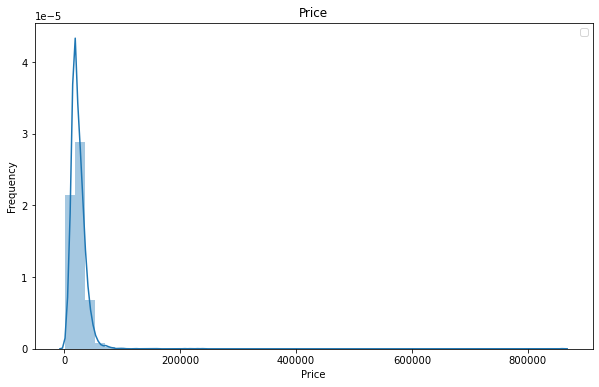

Mean of price:  24568.3835
Standard deviation:  16742.99685916766


In [6]:
#...Plot for distribution of response...#

plt.figure(figsize=(10,6))
sns.distplot(data.price)
plt.title('Price')
plt.legend()
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.ticklabel_format(style='plain', axis='x')
plt.show()

# Mean and standard deviation of response #

print("Mean of price: ", np.mean(data.price))
print("Standard deviation: ", np.std(data.price))

The data needs a log transformation on price. 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


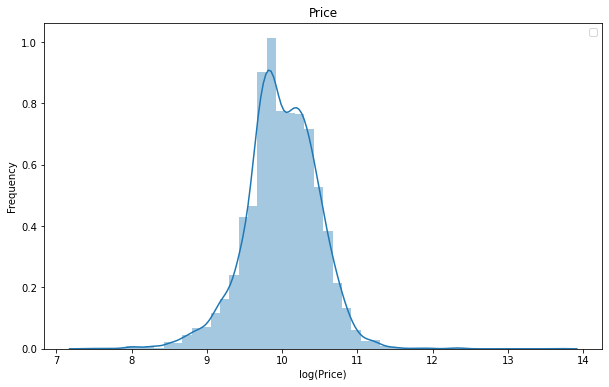

In [7]:
plt.figure(figsize=(10,6))
sns.distplot(np.log(data.price))
plt.title('Price')
plt.legend()
plt.xlabel('log(Price)')
plt.ylabel('Frequency')
plt.ticklabel_format(style='plain', axis='x')
plt.show()

The distribution is much more uniform now with the log transformation. 

<AxesSubplot:xlabel='price'>

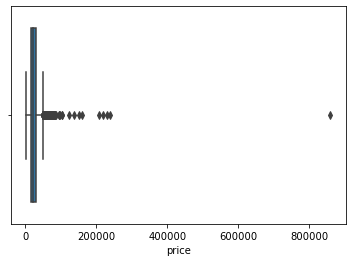

In [8]:
# checking for outlying observations 
sns.boxplot(data.price, orient = "v")

In [9]:
data.price.describe()

count      6000.000000
mean      24568.383500
std       16744.392283
min        1680.000000
25%       16500.000000
50%       21924.000000
75%       29995.000000
max      859000.000000
Name: price, dtype: float64

There appears to be many outliers that we can drop before performing any feature selection. Dropping the outliers should help us avoid possible issues with overfitting to the training data and the complexities that are related to outlying observations. 

In [10]:
data_subset = data[data.price <= 30000]

<AxesSubplot:xlabel='price'>

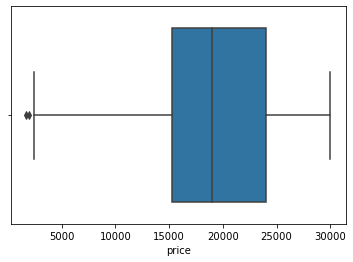

In [11]:
sns.boxplot(data_subset.price)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


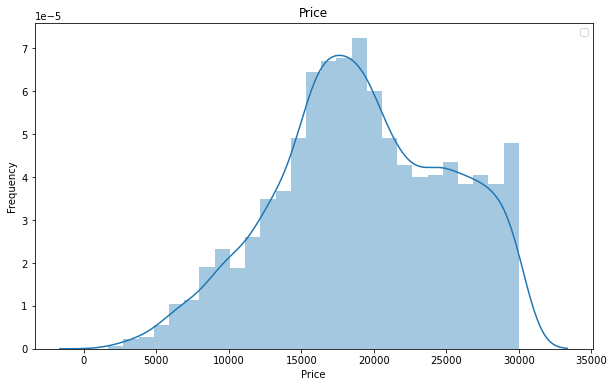

Mean of price:  19205.211827007945
Standard deviation:  5978.306973568847


In [12]:
#...Plot for distribution of response after removing outliers...#

plt.figure(figsize=(10,6))
sns.distplot(data_subset.price)
plt.title('Price')
plt.legend()
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.ticklabel_format(style='plain', axis='x')
plt.show()

# Mean and standard deviation of response #

print("Mean of price: ", np.mean(data_subset.price))
print("Standard deviation: ", np.std(data_subset.price))

The mean and standard deviation have significantly decreased after removing all of the outliers and now we don't need to transform the predictor. The mean and standard deviation have also decreased significantly.

In [13]:
data = data_subset.copy()

In [14]:
print("The final shape of the data after removing outliers is", data.shape)

The final shape of the data after removing outliers is (4532, 57)


### Data Cleaning, Preparation, and EDA
*By Hiba Khatib & Emily Leibfritz*

### brief summary of all the things we did 

After creating all 8 base models, we decided to subset the data into two different ways to improve the analysis of our data. The first subset is the resulting features after our EDA and data preparation. The second way we subsetted the data was based on the features selected by tree based models. Our methods are described in detail below. 

1. Our EDA Selected Features (Hiba & Emily)

We performed data cleaning, preparation and EDA on the data to facilitate feature selection and model training. The first thing we did was fix the data types of some of the columns. All of the boolean columns were encoded as True or False so we mapped those to 1s and 0s. Then, we found that several columns such as horsepower and torque were numerical but contained units. We removed all of the units from these columns and converted them back to numeric. Then, we dropped a set of unique identifiers which were not sigificant to our analysis. We also dropped three columns which represented the interior, and exterior color of the car. These columns had different names for the same color and we did not see them as significant predictors to engineer and encode differently. Then, we dropped a constant predictor which contained the same value for all observations as constant predictors don't provide any meaningful insights. The final step in the cleaning and preparation of the numerical data, we dropped highly correlated features. These were features which represented the same information in two different ways such as the official name of a trim and the id associated with that name. This resulted in us keeping only 14 of the numerical predictors are subsetting for predictors with a correlation of |-.2|. 

# insert summary of categorical data prep 

2. Randomforest and Decision Tree top features (hiba)

In [15]:
# feature engineering

    # encoding True/False as 1/0s
bool_cols = data.dtypes[data.dtypes == bool]
bool_cols = pd.DataFrame(bool_cols).reset_index()
bool_cols = bool_cols['index']
bool_cols = list(bool_cols)
print(bool_cols)
for col in bool_cols:
    data[col] = data[col].map({False: 0, True: 1})
    

    # numerically encoding categorical variables with at most 5 unique values 
cols_map = []
for c in data.columns:
    col_len = (len(data[c].unique()))
    if col_len <=5:
        cols_map.append(c)
[cols_map.remove(c) for c in bool_cols] # removing the boolean columns from the list

    # performing the encoding
le = LabelEncoder()
encoder_dict = {key: None for key in cols_map}
for c in cols_map:
    encoder_dict[c] = data[c].unique()
    col_name = str(c)+"_cat"
    data[col_name] = le.fit_transform(data[c])
    encoder_dict[col_name] = le.fit_transform(encoder_dict[c])
    
    # removing units from numerical columns 

data['front_legroom'] = data['front_legroom'].map(lambda x: x.lstrip('+-').rstrip('in'))
data['width'] = data['width'].map(lambda x: x.lstrip('+-').rstrip('in'))
data['height'] = data['height'].map(lambda x: x.lstrip('+-').rstrip('in'))
data['length'] = data['length'].map(lambda x: x.lstrip('+-').rstrip('in'))
data['wheelbase'] = data['wheelbase'].map(lambda x: x.lstrip('+-').rstrip('in'))
data['back_legroom'] = data['back_legroom'].map(lambda x: x.lstrip('+-').rstrip('in'))
data['maximum_seating'] = data['maximum_seating'].map(lambda x: x.lstrip('+-').rstrip('seating'))
data['fuel_tank_volume'] = data['fuel_tank_volume'].map(lambda x: x.lstrip('+-').rstrip('gal'))
data['power'] = data['power'].str[:3] # keeping only numerical value
data['torque'] = data['torque'].str[:3]

    # converting data types to numerical
data.power = pd.to_numeric(data.power)
data.back_legroom = pd.to_numeric(data.back_legroom)
data.front_legroom = pd.to_numeric(data.front_legroom)
data.width = pd.to_numeric(data.width)
data.height = pd.to_numeric(data.height)
data.length = pd.to_numeric(data.length)
data.wheelbase = pd.to_numeric(data.wheelbase)
data.maximum_seating = pd.to_numeric(data.maximum_seating)
data.fuel_tank_volume = pd.to_numeric(data.fuel_tank_volume)
data.torque = pd.to_numeric(data.torque)

['fleet', 'frame_damaged', 'franchise_dealer', 'has_accidents', 'isCab', 'is_new', 'salvage', 'theft_title']


In [16]:
data.columns

Index(['vin', 'back_legroom', 'body_type', 'city', 'city_fuel_economy',
       'daysonmarket', 'dealer_zip', 'description', 'engine_cylinders',
       'engine_displacement', 'engine_type', 'exterior_color', 'fleet',
       'frame_damaged', 'franchise_dealer', 'franchise_make', 'front_legroom',
       'fuel_tank_volume', 'fuel_type', 'has_accidents', 'height',
       'highway_fuel_economy', 'horsepower', 'interior_color', 'isCab',
       'is_new', 'latitude', 'length', 'listed_date', 'listing_color',
       'listing_id', 'longitude', 'main_picture_url', 'major_options',
       'make_name', 'maximum_seating', 'mileage', 'model_name', 'owner_count',
       'power', 'price', 'salvage', 'savings_amount', 'seller_rating', 'sp_id',
       'sp_name', 'theft_title', 'torque', 'transmission',
       'transmission_display', 'trimId', 'trim_name', 'wheel_system',
       'wheel_system_display', 'wheelbase', 'width', 'year', 'fuel_type_cat',
       'transmission_cat', 'wheel_system_cat', 'wheel_syst

In [17]:
# dropping unique features

data.drop(columns = ['vin', 'listing_id', 'main_picture_url', 'description', 'sp_name', 'make_name', 'city'], inplace = True)

    # color columns
data.drop(columns = ['listing_color', 'interior_color', 'exterior_color'], inplace = True)

print("Data shape after dropping unique features: ", data.shape)

# dropping constant predictor 
print(data.nunique() == 1)
data.drop(columns = ['franchise_dealer'], inplace = True)

# dropping highly correlated columns 

data.drop(columns = ['trim_name', 'engine_type', 'major_options', 'horsepower'], inplace = True)

Data shape after dropping unique features:  (4532, 51)
back_legroom                False
body_type                   False
city_fuel_economy           False
daysonmarket                False
dealer_zip                  False
engine_cylinders            False
engine_displacement         False
engine_type                 False
fleet                       False
frame_damaged               False
franchise_dealer             True
franchise_make              False
front_legroom               False
fuel_tank_volume            False
fuel_type                   False
has_accidents               False
height                      False
highway_fuel_economy        False
horsepower                  False
isCab                       False
is_new                      False
latitude                    False
length                      False
listed_date                 False
longitude                   False
major_options               False
maximum_seating             False
mileage                    

In [18]:
print("Final data shape after cleaning and dropping unnecessary features: ", data.shape)

Final data shape after cleaning and dropping unnecessary features:  (4532, 46)


### Exploring Trends in Categorical Predictors

In [19]:
data_2 = data.copy()
# make seperate df to just look at categorical
o_data = data.drop(columns = ["back_legroom", "wheel_system_display", "wheelbase", "width", "front_legroom", 
                              "fuel_tank_volume", "height", "torque", "maximum_seating","transmission_cat",
                              "power","city_fuel_economy","daysonmarket","dealer_zip","transmission","wheel_system_display_cat",
                              "fuel_type_cat","wheel_system","wheel_system_cat","fuel_type",
                              "engine_displacement","fleet","frame_damaged","has_accidents","highway_fuel_economy",
                              "isCab","is_new","latitude","longitude","mileage","owner_count","salvage",
                              "savings_amount","seller_rating","sp_id","theft_title","year"], axis = 1)
# taken out: "franchise_dealer"
cols = o_data.columns
name = []
unique_value = []
for i in range(0,len(cols)):
    c = cols[i]
    unique = len(data[c].unique())
    unique_value.append(unique)
    name.append(c)

In [20]:
# Create the pandas DataFrame with object columns and their unique values
data_ = {'column': name, 'unique_values':unique_value}
o_unique_values_count = pd.DataFrame(data_)
o_unique_values_count.sort_values(by=['unique_values'])

,column,unique_values
0,body_type,9
1,engine_cylinders,16
7,transmission_display,18
2,franchise_make,34
4,listed_date,286
5,model_name,289
3,length,333
8,trimId,2344
6,price,2485


From this information, we can simply visualize with boxplot any variables until make_name, to see their relevance and adjust them. After that we will look more thoroughly, maybe group data. Consider dropping anything with other 1000 unique values as we only have 6000 rows, so might not be good predictors, but will decide on case by case basis.

[]

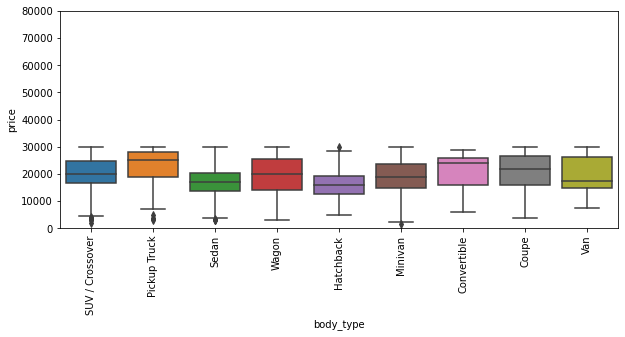

In [21]:
plt.figure(figsize=(10,4))
sns.boxplot(x="body_type",y="price", data = data)
plt.xticks(rotation=90)
plt.ylim(0,80000)

plt.plot()

body_type seems to have a significant trend right away. We cancheck value counts to see if some types are more common than others

In [22]:
data.body_type.value_counts()

SUV / Crossover    2295
Sedan              1503
Pickup Truck        190
Minivan             184
Wagon               115
Hatchback           108
Coupe                98
Convertible          27
Van                  12
Name: body_type, dtype: int64

Have enough observations for each value to be valid, none of the smaller groups stand out substantially, convertible is a little bit spread but that should be fine -> convert to dummies

In [23]:
# change spelling so colummns will be callable
data_2['body_type'] = o_data['body_type'].apply(lambda x: 'SUV_Crossover' if x == 'SUV / Crossover' else 
                                                          'Pickup_Truck' if x == 'Pickup Truck' else
                                                x)
# get dummies
data_2 = pd.get_dummies(data_2, columns=['body_type'], drop_first=True)

[]

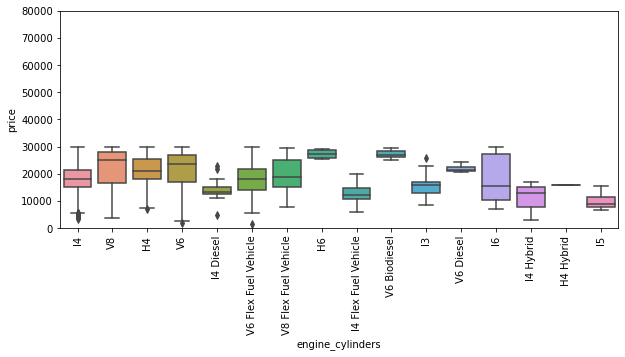

In [24]:
plt.figure(figsize=(10,4))

sns.boxplot(x="engine_cylinders",y="price", data = o_data)
plt.xticks(rotation=90)
plt.ylim(0,80000)
plt.plot()

In [25]:
o_data.engine_cylinders.value_counts()

I4                      2776
V6                      1223
V6 Flex Fuel Vehicle     156
H4                       145
V8                       105
V8 Flex Fuel Vehicle      45
I4 Flex Fuel Vehicle      22
I4 Diesel                 16
I3                        13
I6                        12
H6                         4
V6 Diesel                  4
I5                         4
V6 Biodiesel               3
I4 Hybrid                  3
H4 Hybrid                  1
Name: engine_cylinders, dtype: int64

Turn anything under 100 observations into 'other', if there is only one observation this is not useful data.

In [26]:
data_2['engine_cylinders'] = o_data['engine_cylinders'].apply(lambda x: 'I4' if x == 'I4' else 
                                                          'V6' if x == 'V6' else
                                                          'V8' if x == 'V8' else
                                                          'V6_Flex_Fuel_Vehicle' if x == 'V6 Flex Fuel Vehicle' else
                                                          'H4' if x == 'H4' else
                                                          'other')
data_2.engine_cylinders.value_counts()

I4                      2776
V6                      1223
V6_Flex_Fuel_Vehicle     156
H4                       145
other                    127
V8                       105
Name: engine_cylinders, dtype: int64

[]

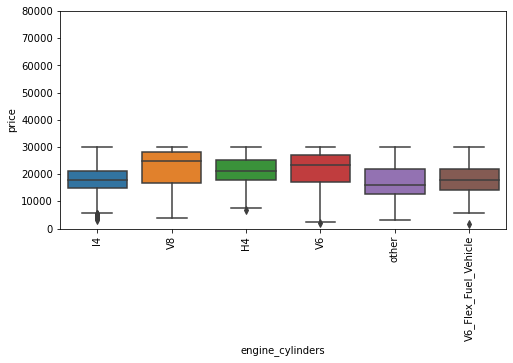

In [27]:
plt.figure(figsize=(8,4))
sns.boxplot(x="engine_cylinders",y="price", data = data_2)
plt.xticks(rotation=90)
plt.ylim(0,80000)
plt.plot()

Other is naturally with bigger range, but this looks better, get dummies for it:

In [28]:
data_2 = pd.get_dummies(data_2, columns=['engine_cylinders'], drop_first=True)

[]

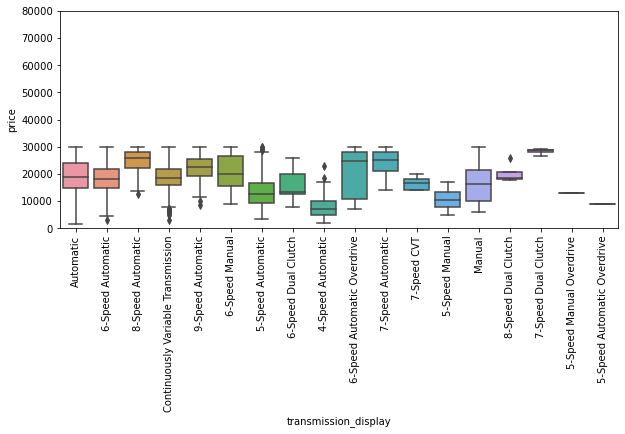

In [29]:
plt.figure(figsize=(10,4))
sns.boxplot(x="transmission_display",y="price", data = o_data)
plt.xticks(rotation=90)
plt.ylim(0,80000)
plt.plot()

Mean and range seem both to be varying, might be valuable column to predict price, check value counts:

In [30]:
data.transmission_display.value_counts().head()

Automatic                             1583
6-Speed Automatic                     1157
Continuously Variable Transmission     934
8-Speed Automatic                      334
9-Speed Automatic                      189
Name: transmission_display, dtype: int64

[]

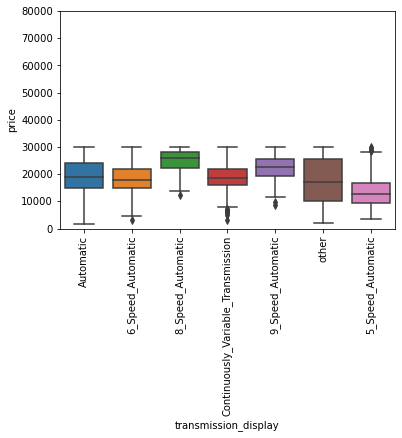

In [31]:
data_2['transmission_display'] = o_data['transmission_display'].apply(lambda x: 'Automatic' if x == 'Automatic' else 
                                                          '6_Speed_Automatic' if x == '6-Speed Automatic' else
                                                          'Continuously_Variable_Transmission' if x == 'Continuously Variable Transmission' else
                                                          '8_Speed_Automatic' if x == '8-Speed Automatic' else
                                                          '9_Speed_Automatic' if x == '9-Speed Automatic' else
                                                          '6_Speed_Automatic' if x == '6-Speed Automatic' else
                                                          '5_Speed_Automatic' if x == '5-Speed Automatic' else
                                                          'other')
plt.figure(figsize=(6,4))
sns.boxplot(x="transmission_display",y="price", data = data_2)
plt.xticks(rotation=90)
plt.ylim(0,80000)
plt.plot()

Looks relevant, change in mean and besides 2 relatively small range -> convert into dummies

In [32]:
# turn those columns into dummies
data_2 = pd.get_dummies(data_2, columns=['transmission_display'], drop_first=True)

[]

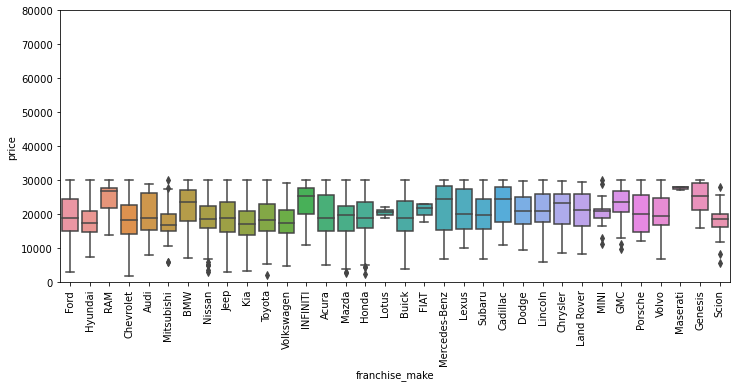

In [33]:
plt.figure(figsize=(12,5))
sns.boxplot(x="franchise_make",y="price", data = o_data)
plt.xticks(rotation=90)
plt.ylim(0,80000)
plt.plot()

This seems to be too many columns to just turn into dummies, and as brand is strongly connected to price this seems an important column to keep -> divide brands into groups depending on their mean price, and label encode these groups.

In [34]:
# look at mean price by group
brand_mean_price=data.groupby('franchise_make', as_index=False)['price'].mean()
brand_mean_price=brand_mean_price.sort_values(by=['price'])
brand_mean_price.head()

,franchise_make,price
16,Kia,17610.859551
25,Mitsubishi,17617.980000
29,Scion,17778.894737
32,Volkswagen,18031.586957
13,Hyundai,18046.270270


In [35]:
# sort the brands into groups with similar means
group_0 = brand_mean_price.iloc[0:8,0]
group_1 = brand_mean_price.iloc[8:14,0]
group_2 = brand_mean_price.iloc[14:19,0]
group_3 = brand_mean_price.iloc[19:25,0]
group_4 = brand_mean_price.iloc[25:34,0]
group_5 = brand_mean_price.iloc[34:38,0]
group_6 = brand_mean_price.iloc[38:40,0]

# write function to get names
def get_names (group):
    final = []
    for i in range(0,len(group)):
        name = group.iloc[i]
        final.append(name)
    return(final)
# list of names in each group
names_0 = get_names(group_0)
names_1 = get_names(group_1)
names_2 = get_names(group_2)
names_3 = get_names(group_3)
names_4 = get_names(group_4)
names_5 = get_names(group_5)
names_6 = get_names(group_6)

# replace each object with a number of their group
data_2['franchise_make'] = o_data['franchise_make'].apply(lambda x: 0 if x in names_0 else
                                                          1 if x in names_1 else
                                                          2 if x in names_2 else
                                                          3 if x in names_3 else
                                                          4 if x in names_4 else
                                                          5 if x in names_5 else
                                                          6 if x in names_6 else
                                                         'wrong')

In [36]:
data.listed_date.value_counts().head()

2020-09-02    163
2020-08-28    119
2020-09-03    110
2020-08-27    109
2020-08-30    105
Name: listed_date, dtype: int64

In [37]:
#simply turn into numerical
import datetime
data_2['listed_date']=pd.to_datetime(data_2["listed_date"]).dt.strftime("%Y%m%d")
data_2['listed_date']=data_2.listed_date.astype(int)
# get correlation
data_2['listed_date'].corr(data_2['price'])

-0.027944370408355405

Has a negative correlation between listing date and price, rather small

In [38]:
data.model_name.value_counts().head()

Escape     166
Rogue      146
Accord     125
Corolla    114
RAV4       108
Name: model_name, dtype: int64

Looking at both head and tail, there is a good distribution of the different model names, not one that is prelevant wherease the rest only has 1 or 2 entries -> group and turn into numeric

In [39]:
# look at grouped mean
make_mean_price=data.groupby('model_name', as_index=False)['price'].mean()
make_mean_price=make_mean_price.sort_values(by=['price'])
make_mean_price.head()

,model_name,price
195,QX4,2000.0
164,Mariner Hybrid,2953.0
95,Explorer Sport Trac,2995.0
101,Five Hundred,3000.0
182,Park Avenue,3000.0


In [40]:
# like with other column, divide 361 rows into 7 groups, different sizes but around same mean
group_0 = make_mean_price.iloc[0:100,0] # 2000-15000
group_1 = make_mean_price.iloc[100:194,0] # 15000-25000 
group_2 = make_mean_price.iloc[194:237,0] # 25000-30000 
group_3 = make_mean_price.iloc[237:279,0] # 30000-35000
group_4 = make_mean_price.iloc[279:329,0] # 35000-50000
group_5 = make_mean_price.iloc[319:352,0] # 50000-10000
group_6 = make_mean_price.iloc[352:362,0] # rest

# list of names in each group
names_0 = get_names(group_0)
names_1 = get_names(group_1)
names_2 = get_names(group_2)
names_3 = get_names(group_3)
names_4 = get_names(group_4)
names_5 = get_names(group_5)
names_6 = get_names(group_6)

# replace each object with a number of their group
data_2['model_name'] = o_data['model_name'].apply(lambda x: 0 if x in names_0 else
                                                          1 if x in names_1 else
                                                          2 if x in names_2 else
                                                          3 if x in names_3 else
                                                          4 if x in names_4 else
                                                          5 if x in names_5 else
                                                          6 if x in names_6 else
                                                         'wrong')

In [41]:
# drop first letter of each row
data_2['trimId'] = data['trimId'].str.slice(1)
# convert to integer
data_2['trimId']=data_2.trimId.astype(int)
# look at correlation
data_2['trimId'].corr(data_2['price'])

0.5706133697377521

In [42]:
# drop categorical version of columns we have numerical copy of
data_2 = data_2.drop(columns=["transmission","wheel_system_display","fuel_type","wheel_system"], axis = 1)

In [43]:
dat_types = pd.DataFrame(data_2.dtypes)

In [44]:
dat_types.value_counts()

uint8      19
float64    18
int64      15
int32       6
dtype: int64

In [45]:
data_2.shape

(4532, 58)

In [46]:
data = data_2

In [47]:
data

,back_legroom,city_fuel_economy,daysonmarket,dealer_zip,engine_displacement,fleet,frame_damaged,franchise_make,front_legroom,fuel_tank_volume,...,engine_cylinders_V6,engine_cylinders_V6_Flex_Fuel_Vehicle,engine_cylinders_V8,engine_cylinders_other,transmission_display_6_Speed_Automatic,transmission_display_8_Speed_Automatic,transmission_display_9_Speed_Automatic,transmission_display_Automatic,transmission_display_Continuously_Variable_Transmission,transmission_display_other
0,36.8,21.0,40,78016,2000.0,0,0,1,42.8,15.5,...,0,0,0,0,0,0,0,1,0,0
2,36.8,23.0,30,37129,2500.0,0,0,1,43.1,15.4,...,0,0,0,0,0,0,0,1,0,0
5,38.2,21.0,161,73069,2000.0,0,0,0,41.5,16.4,...,0,0,0,0,1,0,0,0,0,0
6,40.3,15.0,14,48836,5700.0,0,0,4,41.0,26.0,...,0,0,1,0,0,1,0,0,0,0
7,40.9,21.0,49,12701,2400.0,1,0,0,44.1,18.8,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5994,33.4,23.0,1,95407,2000.0,0,0,1,43.1,12.4,...,0,0,0,0,0,0,0,0,0,1
5995,37.0,20.0,88,15146,2000.0,0,0,3,44.3,18.0,...,0,0,0,0,1,0,0,0,0,0
5996,39.8,22.0,38,77065,2500.0,0,0,0,45.8,18.5,...,0,0,0,0,0,0,0,1,0,0
5997,37.3,22.0,92,84341,2000.0,0,0,1,43.1,15.7,...,0,0,0,0,0,0,0,1,0,0


### Feature Selection 

In [48]:
final_corrs = pd.DataFrame(data.corrwith(data.price)).reset_index().sort_values(by = 0, ascending = False)

final_corr_cols = list(final_corrs.loc[(final_corrs[0] >= 0.2) | (final_corrs[0] <= -0.2)][1:]['index'])
final_corrs.loc[(final_corrs[0] >= 0.2) | (final_corrs[0] <= -0.2)][1:]

,index,0
21,model_name,0.581373
34,year,0.574644
31,trimId,0.570613
23,power,0.406592
30,torque,0.386623
33,width,0.303995
53,transmission_display_8_Speed_Automatic,0.268433
32,wheelbase,0.256636
11,height,0.245438
48,engine_cylinders_V6,0.245117


In [49]:
X = data.copy()

for col in X:
    if col not in final_corr_cols:
        X.drop(col, axis = 1, inplace = True)

X.shape

(4532, 23)

We have 23 predictors which have a reasonable correlation with price which we will be the only predictors we use in our model building. 

When we develop our models, we will print the feature importances and note which features are deemed significant by each model. 

In [50]:
# checking for any new NAs 
X.isna().sum()

city_fuel_economy                         0
engine_displacement                       0
franchise_make                            0
fuel_tank_volume                          1
height                                    1
highway_fuel_economy                      0
length                                    1
mileage                                   0
model_name                                0
owner_count                               0
power                                     0
savings_amount                            0
torque                                    0
trimId                                    0
wheelbase                                 1
width                                     1
year                                      0
wheel_system_cat                          0
wheel_system_display_cat                  0
body_type_Sedan                           0
engine_cylinders_I4                       0
engine_cylinders_V6                       0
transmission_display_8_Speed_Aut

In [51]:
y = data.price 
y.isna().sum()

0

The original dataset had '--' for this one observation. When we performed the data cleaning and prep, these observations were not considered missing but became missing after our feature engineering. We can drop this observation since it is only one row with data missing from the original source. 

In [52]:
X.isna().sum()
X.iloc[29]
X.drop(29, inplace = True)
y.drop(29, inplace = True)

In [53]:
X.to_csv('X.csv')
y.to_csv('y.csv')

In [54]:
clean_X = X.copy()
clean_y = y.copy()

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 4)

### Features Selection using Tree Based Models

Using the tree based methods such as RandomForest and DecisionTrees will allow us to double check if our feature selection has been significant or if it produces better results for base models.

The original shape of our data after removing the outliers is 4532, 58.

After our data cleaning and dropping of the units, we created some NaN values which can be dropped. We can confidently drop these observations because they were initially missing but encoded as '--' which is why we did not initially discover that they were missing. These are 31 observations which we can drop which brings our data shape to 4301, 58

In [56]:
data.shape

(4532, 58)

In [57]:
data_copy = data.copy()
data_copy.dropna(inplace = True)
data_copy.shape

(4501, 58)

In [58]:
X_tree = data_copy.drop(columns = ['price'])
y_tree = data_copy.price

#### Base Random Forest Feature Selection

In [59]:
rf_features = RandomForestRegressor(random_state = 4).fit(X_tree, y_tree)
rf_feats = pd.DataFrame(zip(rf_features.feature_names_in_, rf_features.feature_importances_))

In [60]:
rf_feats.sort_values(by = 1, ascending = False)

,0,1
30,trimId,3.681064e-01
21,model_name,2.059636e-01
23,power,1.224561e-01
20,mileage,8.733049e-02
29,torque,2.501834e-02
0,back_legroom,1.947877e-02
25,savings_amount,1.366988e-02
11,height,1.346977e-02
47,engine_cylinders_V6,9.795723e-03
33,year,9.452366e-03


In [61]:
rf_feats[(rf_feats[1] >= 0.2) | (rf_feats[1] <= -.2)]

,0,1
21,model_name,0.205964
30,trimId,0.368106


In [62]:
base_dt = DecisionTreeRegressor(random_state = 4).fit(X_tree, y_tree)
dt_feats = pd.DataFrame(zip(base_dt.feature_names_in_, base_dt.feature_importances_))
dt_feats.sort_values(by = 1, ascending = False)
dt_feats[(dt_feats[1] >= 0.2) | (dt_feats[1] <= -.2)]

,0,1
21,model_name,0.211757
30,trimId,0.379266


In [63]:
bagged_dt = BaggingRegressor(DecisionTreeRegressor(), random_state = 4, n_estimators = 100).fit(X_tree, y_tree)
f_imp = pd.DataFrame(zip(bagged_dt.feature_names_in_,np.mean([tree.feature_importances_ for tree in bagged_dt.estimators_], axis = 0)))

In [64]:
f_imp.sort_values(by = 1, ascending = False)
f_imp[(f_imp[1] >= 0.2) | (f_imp[1] <= -.2)]

,0,1
21,model_name,0.205927
30,trimId,0.368145


Based on the base Random Forest, the two most significant predictors are model_name and trimId. We can test the performance of a model developed using our feature selection and a model developed using the selected features by the RandomForest to find the best predictors. 

In [65]:
X_tree_subset = X_tree[['model_name', 'trimId']]

X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_tree_subset, y_tree, test_size = 0.3, random_state = 4)

Base MARS model on the tree selected features: 

In [66]:
base_mars1 = Earth().fit(X_train_sub, y_train_sub)
print(base_mars1.summary())
print("Base MARS train RMSE", np.sqrt(base_mars1.mse_))
print("\nBase MARS train R^2", base_mars1.rsq_)
print("\nBASE MARS Test RMSE", mean_squared_error(y_test_sub, base_mars1.predict(X_test_sub), squared = False))
print("\nBASE MARS Test R^2", r2_score(y_test_sub, base_mars1.predict(X_test_sub)))

Earth Model
--------------------------------------
Basis Function   Pruned  Coefficient  
--------------------------------------
(Intercept)      No      35493.1      
h(trimId-67312)  No      -0.228409    
h(67312-trimId)  Yes     None         
model_name       No      3970.31      
h(trimId-32660)  Yes     None         
h(32660-trimId)  No      0.196858     
h(trimId-83763)  Yes     None         
h(83763-trimId)  Yes     None         
h(trimId-89881)  Yes     None         
h(89881-trimId)  No      -2.24943     
h(trimId-78253)  Yes     None         
h(78253-trimId)  No      -6.47566     
h(trimId-76583)  No      2.17212      
h(76583-trimId)  Yes     None         
h(trimId-78985)  No      -3.50747     
h(78985-trimId)  No      7.36778      
h(trimId-82290)  Yes     None         
h(82290-trimId)  No      1.05506      
trimId           Yes     None         
--------------------------------------
MSE: 12520924.7798, GCV: 12709856.5249, RSQ: 0.6517, GRSQ: 0.6466
Base MARS train RMSE 3538

Base MARS model on our selected features: 

In [67]:
base_mars2 = Earth().fit(X_train, y_train)
print(base_mars2.summary())
print("Base MARS train RMSE", np.sqrt(base_mars2.mse_))
print("\nBase MARS train R^2", base_mars2.rsq_)
print("\nBASE MARS Test RMSE", mean_squared_error(y_test, base_mars2.predict(X_test), squared = False))
print("\nBASE MARS Test R^2", r2_score(y_test, base_mars2.predict(X_test)))

Earth Model
-----------------------------------------------
Basis Function            Pruned  Coefficient  
-----------------------------------------------
(Intercept)               No      -696322      
h(trimId-67312)           Yes     None         
h(67312-trimId)           No      -0.126974    
model_name                No      2187.29      
power                     No      14.7161      
h(mileage-116656)         No      -0.032541    
h(116656-mileage)         No      0.0639984    
wheel_system_display_cat  No      -355.43      
engine_cylinders_V6       No      1588.48      
torque                    No      11.9225      
h(trimId-37340)           Yes     None         
h(37340-trimId)           No      0.187547     
wheel_system_cat          No      -399.524     
h(savings_amount-4356)    No      2.82244      
h(4356-savings_amount)    No      -0.259224    
year                      No      351.544      
body_type_Sedan           No      -761.063     
h(city_fuel_economy-32)   Ye

The model's performance is much better using the features selected by our analysis than the tree based models. The R^2 is much greater on our subset's test data even though there does appear to be some slight overfitting. Overfitting does not appear to be an issue with the tree based models selected features but the model's performance is much worse. 

The main takeaway from this analysis is that our selected features resulted in overfitting but generally well performing model. This was true for our initial model development in which most of our models overfit even with extensive tuning and generally had much higher RMSE's at the base model and tuned model.

Another method for finding the best features is by running a base MARS model on our original data to find the best overall features. 

In [68]:
X_tree.shape

(4501, 57)

In [69]:
mars_feats = Earth().fit(X_tree, y_tree)
print(mars_feats.summary())

Earth Model
-------------------------------------------------------------
Basis Function                          Pruned  Coefficient  
-------------------------------------------------------------
(Intercept)                             No      -901747      
h(trimId-67983)                         No      -0.0679866   
h(67983-trimId)                         Yes     None         
model_name                              No      2059.74      
power                                   No      24.8064      
h(mileage-117301)                       No      -0.0337709   
h(117301-mileage)                       No      0.0601967    
wheel_system_cat                        No      -368.638     
engine_cylinders_V6_Flex_Fuel_Vehicle   No      -3305.3      
fleet                                   No      -1080.02     
h(savings_amount-1580)                  No      0.8081       
h(1580-savings_amount)                  Yes     None         
h(latitude-30.4119)                     No      -45.1318  

In [70]:
print("Base MARS train RMSE", np.sqrt(mars_feats.mse_))
print("\nBase MARS train R^2", mars_feats.rsq_)

Base MARS train RMSE 2613.2269980328842

Base MARS train R^2 0.8086796290659015


In [71]:
print("Checking performance on split data: \n")
X_train_mars, X_test_mars, y_train_mars, y_test_mars = train_test_split(X_tree, y_tree, random_state = 4, test_size = 0.3)
random.seed(4)
mars_feats2 = Earth(feature_importance_type = 'rss').fit(X_train_mars, y_train_mars)
print("Base MARS Train RMSE:", np.sqrt(mars_feats2.mse_))
print("\nBase MARS Train R^2", mars_feats2.rsq_)
print("\nBase MARS Test RMSE:", mean_squared_error(y_test_mars, mars_feats2.predict(X_test_mars), squared = False))
print("\nBase MARS Test R^2", r2_score(y_test_mars, mars_feats2.predict(X_test_mars)))

Checking performance on split data: 

Base MARS Train RMSE: 2629.4932798721898

Base MARS Train R^2 0.8076510034139941

Base MARS Test RMSE: 2619.6932550056486

Base MARS Test R^2 0.8045046459514393


In [72]:
print(mars_feats2.summary_feature_importances(sort_by = 'rss'))

                                                            rss
model_name                                                  0.43   
mileage                                                     0.36   
power                                                       0.09   
year                                                        0.06   
wheel_system_cat                                            0.02   
engine_cylinders_V6_Flex_Fuel_Vehicle                       0.01   
fleet                                                       0.01   
savings_amount                                              0.01   
engine_cylinders_I4                                         0.00   
city_fuel_economy                                           0.00   
trimId                                                      0.00   
listed_date                                                 0.00   
latitude                                                    0.00   
transmission_display_6_Speed_Automatic              

The selected features by MARS result in the best performance on the training data and the testing data. There is no overfitting or underfitting and the R^2 has improved, albeit marginally. 

Thus, we will perform the rest of our analysis with the top features selected by the best MARS model. These features are:

model_name                                                  : **0.43**   
mileage                                                     **0.36**  
power                                                      **0.09**    
year                                                        **0.06**   
wheel_system_cat                                            **0.02**  
engine_cylinders_V6_Flex_Fuel_Vehicle                       **0.01**   
fleet                                                       **0.01**   
savings_amount                                              **0.01** 

Final data subsetting and split:

In [73]:
# dropping the 31 missing values from the main/original data

data.dropna(inplace = True)
y_mars = data.price
data.drop(columns = ['price'], inplace = True)
print("Final overall training data shape", data.shape)
print("Final response variable shape", y_mars.shape)

# subsetting for the final selected features

X_mars= data[['model_name', 'mileage', 'power', 'year', 'wheel_system_cat', 'engine_cylinders_V6_Flex_Fuel_Vehicle', 'fleet', 'savings_amount']]

# splitting the final data! 

X_train_mars, X_test_mars, y_train_mars, y_test_mars = train_test_split(X_mars, y_mars, test_size = 0.3, random_state = 4)

Final overall training data shape (4501, 57)
Final response variable shape (4501,)


We will develop our models using both the features found during our EDA and the models using the features found based on the MARS model analysis.

## Developing the model: Hyperparameter tuning

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.**

Put each model in a section of its name and mention the name of the team-member tuning the model. Below is an example:

# NOTE!!!!
## Please read my new analysis above and new feature selection. keep all of your old work but rerun the models with the new split data using the selected features by MARS 

## X_train_mars, y_train_mars etc are the names of the data which have MARS feature selection. 

# ALWAYS USE RANDOM_STATE = 4

Throughout our model development, we ran our analysis on both our selected features and the random forest's selected features to observe the difference in performance. Generally, we anticipate that the models developed using the features selected by random forest will perform better. 

X_train, y_train, X_test, and y_test represent the data which contains the feature selection resulting from our EDA and analysis while X_train_mars, y_train_mars, X_test_mars, and y_test_mars represent the data which contains the features selected by the Random Forest model. 

### Lasso, Ridge & Stepwise Selection
*By Emily Leibfritz*

### MARS & Bagging MARS 
*By Hiba Khatib*

#### Tuning MARS models

Since we already performed base MARS model analysis to inform our feature selection, we can continue with tuning MARS to achieve better results. The first set of tuning will be on the MARS selected features then we will also tuning on our selected features.

In [405]:
random.seed(4)
opt_mars = pd.DataFrame(columns = {'degree', 'R2', 'RMSE'})
iter_num = 0
cv = KFold(n_splits=5, random_state=4, shuffle=True)
for i in range(1, 8):
    
    MARS_model = Earth(max_terms=500, max_degree=i)
    r2 = cross_val_score(MARS_model, X_train_mars, y_train_mars, cv=5, scoring='r2')
    
    mean_r2 = r2.mean()
    
    rmse = cross_val_score(MARS_model, X_train_mars, y_train_mars, cv= 5, scoring='neg_root_mean_squared_error')
    mean_rmse = abs(rmse).mean()
    
    
    opt_mars.loc[iter_num, 'degree'] = i
    opt_mars.loc[iter_num, 'R2'] = mean_r2
    opt_mars.loc[iter_num, 'RMSE'] = mean_rmse
    iter_num += 1

In [407]:
opt_mars.sort_values(by = 'R2', ascending = False).head(1)

,R2,RMSE,degree
4,0.790333,2742.648575,5


In [409]:
opt_mars.sort_values(by = 'RMSE', ascending = True).head(1)

,R2,RMSE,degree
4,0.790333,2742.648575,5


The optimal degree is 5 for both R2 and RMSE. 

In [410]:
fit_mars1 = Earth(max_terms=1000, max_degree= 5, feature_importance_type = "rss").fit(X_train_mars, y_train_mars)
print(fit_mars1.summary())

Earth Model
----------------------------------------------------------------------------------------------
Basis Function                                                          Pruned  Coefficient   
----------------------------------------------------------------------------------------------
(Intercept)                                                             No      -0.867045     
year                                                                    No      -872.929      
model_name*year                                                         No      1.1003        
power*year                                                              No      0.0247296     
h(mileage-118799)*year                                                  No      3.49146e-05   
h(118799-mileage)*year                                                  Yes     None          
wheel_system_cat*year                                                   No      -0.432392     
engine_cylinders_V6_Flex_Fuel_Vehicle*

In [411]:
print("Performance on MARS feature selection:\n")
print("Tuned MARS Train RMSE:", np.sqrt(fit_mars1.mse_))
print("Tuned MARS Train R^2 value: ", fit_mars1.rsq_)
print("Tuned MARS Test RMSE:",mean_squared_error(y_test_mars, fit_mars1.predict(X_test_mars), squared = False) )
print("Tuned MARS Test R^2:", r2_score(y_test_mars, fit_mars1.predict(X_test_mars)))

Performance on MARS feature selection:

Tuned MARS Train RMSE: 2705.691008032262
Tuned MARS Train R^2 value:  0.7963416638745415
Tuned MARS Test RMSE: 2679.9773361980965
Tuned MARS Test R^2: 0.7954036885971033


In [412]:
print("Feature importance by RSS on MARS feature selection\n")
print(fit_mars1.summary_feature_importances(sort_by = 'rss'))

Feature importance by RSS on MARS feature selection

                                          rss
year                                      0.59   
model_name                                0.24   
power                                     0.09   
mileage                                   0.05   
wheel_system_cat                          0.02   
engine_cylinders_V6_Flex_Fuel_Vehicle     0.01   
fleet                                     0.00   
savings_amount                            0.00   



Performance on our feature selection: 

In [413]:
random.seed(4)
opt_mars2 = pd.DataFrame(columns = {'degree', 'R2', 'RMSE'})
iter_num = 0
cv = KFold(n_splits=5, random_state=4, shuffle=True)
for i in range(1, 8):
    
    MARS_model = Earth(max_terms=500, max_degree=i)
    r2 = cross_val_score(MARS_model, X_train, y_train, cv=5, scoring='r2')
    
    mean_r2 = r2.mean()
    
    rmse = cross_val_score(MARS_model, X_train, y_train, cv= 5, scoring='neg_root_mean_squared_error')
    mean_rmse = abs(rmse).mean()
    
    
    opt_mars2.loc[iter_num, 'degree'] = i
    opt_mars2.loc[iter_num, 'R2'] = mean_r2
    opt_mars2.loc[iter_num, 'RMSE'] = mean_rmse
    iter_num += 1

In [414]:
print(opt_mars2.sort_values(by = 'R2', ascending = False).head(1))
print(opt_mars2.sort_values(by = 'RMSE', ascending = True).head(1))

        R2         RMSE degree
5  0.81581  2560.543379      6
        R2         RMSE degree
5  0.81581  2560.543379      6


**The best degree for both R^2 and RMSE is 6**

In [415]:
fit_mars2 = Earth(max_terms=1000, max_degree= 6, feature_importance_type = "rss").fit(X_train, y_train)
print(fit_mars2.summary())

Earth Model
----------------------------------------------------------------------------
Basis Function                                        Pruned  Coefficient   
----------------------------------------------------------------------------
(Intercept)                                           No      7265.17       
h(trimId-67312)                                       No      -0.385114     
h(67312-trimId)                                       No      -0.0784129    
model_name                                            No      -460005       
power                                                 No      50.5903       
h(mileage-116656)                                     No      -0.0256394    
h(116656-mileage)                                     No      0.0538941     
wheel_system_display_cat                              Yes     None          
h(trimId-60496)*h(67312-trimId)                       No      0.00181749    
h(60496-trimId)*h(67312-trimId)                       Yes     No

In [416]:
print("Performance on MARS feature selection:\n")
print("Tuned MARS Train RMSE:", np.sqrt(fit_mars2.mse_))
print("Tuned MARS Train R^2 value: ", fit_mars2.rsq_)
print("Tuned MARS Test RMSE:",mean_squared_error(y_test, fit_mars2.predict(X_test), squared = False) )
print("Tuned MARS Test R^2:", r2_score(y_test, fit_mars2.predict(X_test)))

Performance on MARS feature selection:

Tuned MARS Train RMSE: 2466.834715144428
Tuned MARS Train R^2 value:  0.829696074769481
Tuned MARS Test RMSE: 2743.978978341708
Tuned MARS Test R^2: 0.7894121729348178


In [417]:
print("Feature importance by RSS on MARS feature selection\n")
print(fit_mars2.summary_feature_importances(sort_by = 'rss'))

Feature importance by RSS on MARS feature selection

                                           rss
model_name                                 0.27   
year                                       0.26   
mileage                                    0.24   
power                                      0.11   
trimId                                     0.07   
wheel_system_display_cat                   0.02   
engine_cylinders_V6                        0.01   
highway_fuel_economy                       0.01   
height                                     0.01   
city_fuel_economy                          0.00   
engine_displacement                        0.00   
savings_amount                             0.00   
torque                                     0.00   
franchise_make                             0.00   
owner_count                                0.00   
wheelbase                                  0.00   
width                                      0.00   
length                           

Results and Takeaways: 

The MARS selected features model seems to outperform the model developed on our subset. There is less overfitting despite the slightly worse R^2. This makes sense because the original MARS feature selection ensured that we kept the features which best represented the data and thus it is less likely to experience over or underfitting as in our selected features. The pruning ensures that the model is performing as optimally as possible with the base parameters. 

It is also important to note that the performance on the model with the tuned degree is not significantly better than the performance on the base MARS model with the MARS selected features.

#### Bagging MARS

**First we will bag the best features selected by MARS. We will do a base MARS fitted with the MARS feature data and then a the best MARS feature.**

In [422]:
# bagging the base model for reference
bagging_base = BaggingRegressor(base_estimator = Earth(feature_importance_type = 'rss'), 
                                random_state = 4).fit(X_train_mars, y_train_mars)
best_rmse = 10000
best_r2 = 0
for estimator in bagging_base.estimators_:
    if np.sqrt(estimator.mse_) < best_rmse:
        best_rmse = np.sqrt(estimator.mse_)
    if estimator.rsq_ > best_r2:
        best_r2 = estimator.rsq_
print("Bagged base MARS model Train RMSE:", best_rmse)
print("R^2 on Train data", best_r2)
print("Bagged base MARS model Test RMSE:", mean_squared_error(y_test_mars, bagging_base.predict(X_test_mars), squared = False))
print("R^2 on Test data:", r2_score(y_test_mars, bagging_base.predict(X_test_mars)))
print("Feature importances show the same feature importances as the unbagged MARS models.")
# for estimator in bagging_base.estimators_:
#     print(estimator.summary_feature_importances(sort_by = "rss"))

Bagged base MARS model Train RMSE: 2761.6200070905847
R^2 on Train data 0.9588173903334842
Bagged base MARS model Test RMSE: 2788.600146839992
R^2 on Test data: 0.7784824962191642
Feature importances show the same feature importances as the unbagged MARS models.


**Now we will bag the best MARS model found on the MARS selected features and also tune the bagging grid for this model.** 

In [424]:
# bagging the best estimator found on the MARS selected features

bagging_mars = BaggingRegressor(base_estimator = Earth(max_terms=1000, max_degree= 5, feature_importance_type = "rss")).fit(X_train_mars, y_train_mars)
best_rmse = 10000
best_r2 = 0
for estimator in bagging_mars.estimators_:
    if np.sqrt(estimator.mse_) < best_rmse:
        best_rmse = np.sqrt(estimator.mse_)
    if estimator.rsq_ > best_r2:
        best_r2 = estimator.rsq_
print("Bagged base MARS model Train RMSE:", best_rmse)
print("R^2 on Train data", best_r2)
print("Bagged base MARS model Test RMSE:", mean_squared_error(y_test_mars, bagging_mars.predict(X_test_mars), squared = False))
print("R^2 on Test data:", r2_score(y_test_mars, bagging_mars.predict(X_test_mars)))
print("Feature importances are consistent.")

Bagged base MARS model Train RMSE: 2612.6987983602867
R^2 on Train data 0.963612437865765
Bagged base MARS model Test RMSE: 2737.9654132203773
R^2 on Test data: 0.7864539845171037
Feature importances are consistent.


In [428]:
# coarse grid search: optimizing bagging model 

bagging_opt = {'bootstrap': [True, False], 
              'bootstrap_features': [True, False],
               'max_samples': [0.5, 0.75,1.0],
              'max_features': [0.5, 0.75,1.0]}

opt_grid = RandomizedSearchCV(estimator =  BaggingRegressor(base_estimator = Earth(max_degree= 5, feature_importance_type = "rss"), random_state =4), \
                        param_distributions = bagging_opt, verbose = 1, n_jobs = -1, scoring = 'neg_root_mean_squared_error')
opt_grid.fit(X_train_mars, y_train_mars)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(estimator=BaggingRegressor(base_estimator=Earth(feature_importance_type='rss',
                                                                   max_degree=5),
                                              random_state=4),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'bootstrap_features': [True, False],
                                        'max_features': [0.5, 0.75, 1.0],
                                        'max_samples': [0.5, 0.75, 1.0]},
                   scoring='neg_root_mean_squared_error', verbose=1)

In [429]:
print("The best BaggingRegressor coarse grid parameters:", opt_grid.best_params_)

best_rmse = 10000
best_r2 = 0
for estimator in opt_grid.best_estimator_.estimators_:
    if np.sqrt(estimator.mse_) < best_rmse:
        best_rmse = np.sqrt(estimator.mse_)
    if estimator.rsq_ > best_r2:
        best_r2 = estimator.rsq_

print("Tuned BaggingRegressor Train RMSE:", best_rmse)
print("Tuned BaggingRegressor R2:", best_r2)
print("Tuned BaggingRegressor Test RMSE: ", mean_squared_error(y_test_mars, opt_grid.predict(X_test_mars), squared = False))
print("Tuned BaggingRegressor R2", r2_score(y_test_mars, opt_grid.predict(X_test_mars)))

The best BaggingRegressor coarse grid parameters: {'max_samples': 0.75, 'max_features': 0.5, 'bootstrap_features': False, 'bootstrap': False}
Tuned BaggingRegressor Train RMSE: 3040.6124116396736
Tuned BaggingRegressor R2: 0.9284106503760392
Tuned BaggingRegressor Test RMSE:  2914.9556727676986
Tuned BaggingRegressor R2 0.7579531323185931


In [2]:
# fine grid search

bagging_opt2 = {'max_samples': np.arange(0.1, 0.75, .2),
              'max_features': np.arange(0.5, 1, .2)}

opt_grid2 = RandomizedSearchCV(estimator =  BaggingRegressor(base_estimator = Earth(max_degree= 5, feature_importance_type = "rss"), \
                                                             random_state =4, bootstrap_features = False,\
                                                            bootstrap = False),  param_distributions = bagging_opt2, verbose = 1,\
                               n_jobs = -1, scoring = 'neg_root_mean_squared_error', random_state = 4, n_iter = 3)
opt_grid2.fit(X_train_mars, y_train_mars)

In [438]:
print("The best BaggingRegressor fine parameters:", opt_grid2.best_params_)

best_rmse = 10000
best_r2 = 0
for estimator in opt_grid2.best_estimator_.estimators_:
    if np.sqrt(estimator.mse_) < best_rmse:
        best_rmse = np.sqrt(estimator.mse_)
    if estimator.rsq_ > best_r2:
        best_r2 = estimator.rsq_

print("Tuned BaggingRegressor Train RMSE:", best_rmse)
print("Tuned BaggingRegressor R2:", best_r2)
print("Tuned BaggingRegressor Test RMSE: ", mean_squared_error(y_test_mars, opt_grid2.predict(X_test_mars), squared = False))
print("Tuned BaggingRegressor R2", r2_score(y_test_mars, opt_grid2.predict(X_test_mars)))

The best BaggingRegressor fine parameters: {'max_samples': 0.6, 'max_features': 0.9}
Tuned BaggingRegressor Train RMSE: 2620.6858359626726
Tuned BaggingRegressor R2: 0.9624349584512664
Tuned BaggingRegressor Test RMSE:  3145.216344284546
Tuned BaggingRegressor R2 0.718202844680064


**Finally we will bag the best MARS model found on our selected features and also tune the bagging grid for this model.**

In [75]:
# bagging the base model for reference
bagging_base = BaggingRegressor(base_estimator = Earth(feature_importance_type = 'rss'), 
                                random_state = 4).fit(X_train, y_train)
best_rmse = 10000
best_r2 = 0
for estimator in bagging_base.estimators_:
    if np.sqrt(estimator.mse_) < best_rmse:
        best_rmse = np.sqrt(estimator.mse_)
    if estimator.rsq_ > best_r2:
        best_r2 = estimator.rsq_
print("Bagged base MARS model Train RMSE:", best_rmse)
print("R^2 on Train data", best_r2)
print("Bagged base MARS model Test RMSE:", mean_squared_error(y_test, bagging_base.predict(X_test), squared = False))
print("R^2 on Test data:", r2_score(y_test, bagging_base.predict(X_test)))
print("Feature importances show the same feature importances as the unbagged MARS models.")
# for estimator in bagging_base.estimators_:
#     print(estimator.summary_feature_importances(sort_by = "rss"))

Bagged base MARS model Train RMSE: 2597.9794766802843
R^2 on Train data 0.9632264134685602
Bagged base MARS model Test RMSE: 2869.7450024161185
R^2 on Test data: 0.7696658565959801
Feature importances show the same feature importances as the unbagged MARS models.


In [76]:
# bagging the best estimator found on our selected features

bagging_mars = BaggingRegressor(base_estimator = Earth(max_degree= 6, feature_importance_type = "rss")).fit(X_train, y_train)
best_rmse = 10000
best_r2 = 0
for estimator in bagging_mars.estimators_:
    if np.sqrt(estimator.mse_) < best_rmse:
        best_rmse = np.sqrt(estimator.mse_)
    if estimator.rsq_ > best_r2:
        best_r2 = estimator.rsq_
print("Bagged base MARS model Train RMSE:", best_rmse)
print("R^2 on Train data", best_r2)
print("Bagged base MARS model Test RMSE:", mean_squared_error(y_test, bagging_mars.predict(X_test), squared = False))
print("R^2 on Test data:", r2_score(y_test, bagging_mars.predict(X_test)))
print("Feature importances are consistent.")

Bagged base MARS model Train RMSE: 2280.922799036446
R^2 on Train data 0.9720576756220233
Bagged base MARS model Test RMSE: 2940.2215805350525
R^2 on Test data: 0.7582136243310234
Feature importances are consistent.


In [77]:
# coarse grid search: optimizing bagging model 

bagging_opt = {'max_samples': [0.5, 0.75,1.0],
              'max_features': [0.5, 0.75,1.0]}

opt_grid = RandomizedSearchCV(estimator =  BaggingRegressor(base_estimator = Earth(max_degree= 6, feature_importance_type = "rss"), random_state =4), \
                        param_distributions = bagging_opt, verbose = 1, n_jobs = -1, scoring = 'neg_root_mean_squared_error')
opt_grid.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


RandomizedSearchCV(estimator=BaggingRegressor(base_estimator=Earth(feature_importance_type='rss',
                                                                   max_degree=6),
                                              random_state=4),
                   n_jobs=-1,
                   param_distributions={'max_features': [0.5, 0.75, 1.0],
                                        'max_samples': [0.5, 0.75, 1.0]},
                   scoring='neg_root_mean_squared_error', verbose=1)

In [79]:
print("The best BaggingRegressor coarse grid parameters:", opt_grid.best_params_)

best_rmse = 10000
best_r2 = 0
for estimator in opt_grid.best_estimator_.estimators_:
    if np.sqrt(estimator.mse_) < best_rmse:
        best_rmse = np.sqrt(estimator.mse_)
    if estimator.rsq_ > best_r2:
        best_r2 = estimator.rsq_

The best BaggingRegressor coarse grid parameters: {'max_samples': 1.0, 'max_features': 1.0}


In [80]:
print("Tuned BaggingRegressor Train RMSE:", best_rmse)
print("Tuned BaggingRegressor R2:", best_r2)
print("Tuned BaggingRegressor Test RMSE: ", mean_squared_error(y_test, opt_grid.predict(X_test), squared = False))
print("Tuned BaggingRegressor R2", r2_score(y_test, opt_grid.predict(X_test)))

Tuned BaggingRegressor Train RMSE: 2263.553508108404
Tuned BaggingRegressor R2: 0.9721508909839748
Tuned BaggingRegressor Test RMSE:  2615.7244744165496
Tuned BaggingRegressor R2 0.8086380025887268


**Analysis of Results** 



We 

### Decision Trees & Bagging Decision Trees
*By Nicole Birova*

### Random forest 
*By Hiba Khatib*

**The first set of Random Forests will be performed on the MARS selected features.**

In [81]:
base_rf = RandomForestRegressor(random_state = 4).fit(X_train_mars, y_train_mars)
print("Base RandomForest Test RMSE: ", mean_squared_error(y_test_mars, base_rf.predict(X_test_mars), squared = False))
print("Base RandomForest Train RMSE: ", mean_squared_error(y_train_mars, base_rf.predict(X_train_mars), squared = False))
print("Base RandomForest R^2: ", r2_score(y_test_mars, base_rf.predict(X_test_mars)))

Base RandomForest Test RMSE:  2369.927998736765
Base RandomForest Train RMSE:  936.6562391425674
Base RandomForest R^2:  0.840005202649853


In [82]:
base_rf_feats = pd.DataFrame(zip(base_rf.feature_names_in_, base_rf.feature_importances_)).reset_index()
base_rf_feats.sort_values(by = base_rf_feats.columns[2], ascending = False)

,index,0,1
3,3,year,0.343984
0,0,model_name,0.242288
2,2,power,0.169672
1,1,mileage,0.147431
7,7,savings_amount,0.055077
4,4,wheel_system_cat,0.030605
6,6,fleet,0.005677
5,5,engine_cylinders_V6_Flex_Fuel_Vehicle,0.005266


#### Coarse grid search

In [83]:
rf_params = {'n_estimators': [250, 500, 700], 
            'max_depth': [4, 6, 8], 
            'max_leaf_nodes': range(2, 300, 75),
            'bootstrap': [True, False]}

rf_grid = GridSearchCV(RandomForestRegressor(random_state = 4), rf_params, n_jobs = -1, verbose = 1, 
                       scoring = 'neg_root_mean_squared_error')
rf_grid.fit(X_train_mars, y_train_mars)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(estimator=RandomForestRegressor(random_state=4), n_jobs=-1,
             param_grid={'bootstrap': [True, False], 'max_depth': [4, 6, 8],
                         'max_leaf_nodes': range(2, 300, 75),
                         'n_estimators': [250, 500, 700]},
             scoring='neg_root_mean_squared_error', verbose=1)

In [84]:
print("Best RandomForest parameters:", rf_grid.best_params_)
print("Best model train RMSE:", mean_squared_error(y_train_mars, rf_grid.predict(X_train_mars), squared = False))
print("Best model test RMSE:", mean_squared_error(y_test_mars, rf_grid.predict(X_test_mars), squared = False))
print("Best model R^2:", r2_score(y_test_mars, rf_grid.predict(X_test_mars)))

Best RandomForest parameters: {'bootstrap': True, 'max_depth': 8, 'max_leaf_nodes': 152, 'n_estimators': 250}
Best model train RMSE: 2115.1675658763616
Best model test RMSE: 2512.4214163945476
Best model R^2: 0.8201872303352222


In [85]:
rf_feats = pd.DataFrame(zip(rf_grid.best_estimator_.feature_names_in_, rf_grid.best_estimator_.feature_importances_)).reset_index()
rf_feats.sort_values(by = rf_feats.columns[2], ascending = False)

,index,0,1
3,3,year,0.381062
0,0,model_name,0.277125
2,2,power,0.157509
1,1,mileage,0.128131
4,4,wheel_system_cat,0.028307
7,7,savings_amount,0.020797
5,5,engine_cylinders_V6_Flex_Fuel_Vehicle,0.004691
6,6,fleet,0.002377


In [86]:
rf_results = pd.DataFrame(rf_grid.cv_results_)
rf_results.head(2)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_max_depth,param_max_leaf_nodes,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.557264,0.023031,0.025252,0.004624,True,4,2,250,"{'bootstrap': True, 'max_depth': 4, 'max_leaf_...",-4695.255873,-4812.806394,-4908.589487,-5099.346146,-5320.735759,-4967.346732,220.760601,55
1,1.220450,0.056842,0.046306,0.003225,True,4,2,500,"{'bootstrap': True, 'max_depth': 4, 'max_leaf_...",-4692.579909,-4812.292887,-4926.218685,-5100.746773,-5321.148496,-4970.597350,220.974408,58


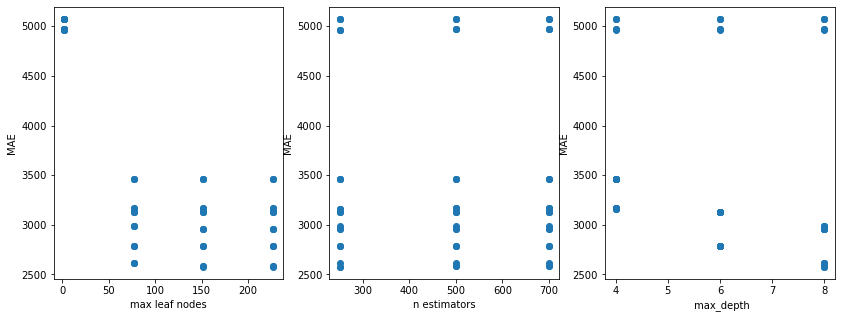

In [90]:
fig, axes = plt.subplots(1,3,figsize=(14,5))
plt.subplots_adjust(wspace=0.2)
axes[0].plot(rf_results.param_max_leaf_nodes, (-rf_results.mean_test_score), 'o')
axes[0].set_xlabel('max leaf nodes')
axes[0].set_ylabel('MAE')
axes[1].plot(rf_results.param_n_estimators,(-rf_results.mean_test_score), 'o')
axes[1].set_xlabel('n estimators')
axes[1].set_ylabel('MAE');
axes[2].plot(rf_results.param_max_depth,(-rf_results.mean_test_score), 'o')
axes[2].set_xlabel(' max_depth')
axes[2].set_ylabel('MAE');

#### Fine Grid Search

In [92]:
rf_params2 = {'n_estimators': [400, 700, 900], 
            'max_depth': [6, 8, 10], 
            'max_leaf_nodes': [250, 300]}

rf_grid2 = GridSearchCV(RandomForestRegressor(random_state = 4, bootstrap = True), rf_params2, n_jobs = -1, verbose = 1, 
                       scoring = 'neg_root_mean_squared_error')
rf_grid2.fit(X_train_mars, y_train_mars)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(estimator=RandomForestRegressor(random_state=4), n_jobs=-1,
             param_grid={'max_depth': [6, 8, 10], 'max_leaf_nodes': [250, 300],
                         'n_estimators': [400, 700, 900]},
             scoring='neg_root_mean_squared_error', verbose=1)

In [93]:
print("Best RandomForest parameters:", rf_grid2.best_params_)
print("Best model train RMSE:", mean_squared_error(y_train_mars, rf_grid2.predict(X_train_mars), squared = False))
print("Best model test RMSE:", mean_squared_error(y_test_mars, rf_grid2.predict(X_test_mars), squared = False))
print("Best model R^2:", r2_score(y_test_mars, rf_grid2.predict(X_test_mars)))
rf_feats2 = pd.DataFrame(zip(rf_grid2.best_estimator_.feature_names_in_, rf_grid2.best_estimator_.feature_importances_)).reset_index()
rf_feats2.sort_values(by = rf_feats2.columns[2], ascending = False)

Best RandomForest parameters: {'max_depth': 10, 'max_leaf_nodes': 300, 'n_estimators': 400}
Best model train RMSE: 1760.3116869136927
Best model test RMSE: 2411.105836013617
Best model R^2: 0.8343970360415414


,index,0,1
3,3,year,0.366251
0,0,model_name,0.264704
2,2,power,0.163420
1,1,mileage,0.134579
7,7,savings_amount,0.032096
4,4,wheel_system_cat,0.029813
5,5,engine_cylinders_V6_Flex_Fuel_Vehicle,0.005402
6,6,fleet,0.003734


**Now we will continue with analysis on our selected features**

In [94]:
base_rf = RandomForestRegressor(random_state = 4).fit(X_train, y_train)
print("Base RandomForest Test RMSE: ", mean_squared_error(y_test, base_rf.predict(X_test), squared = False))
print("Base RandomForest Train RMSE: ", mean_squared_error(y_train, base_rf.predict(X_train), squared = False))
print("Base RandomForest R^2: ", r2_score(y_test, base_rf.predict(X_test)))

Base RandomForest Test RMSE:  2320.299016980909
Base RandomForest Train RMSE:  811.3938236091882
Base RandomForest R^2:  0.8494226618329384


In [95]:
base_rf_feats = pd.DataFrame(zip(base_rf.feature_names_in_, base_rf.feature_importances_)).reset_index()
base_rf_feats.sort_values(by = base_rf_feats.columns[2], ascending = False)

,index,0,1
13,13,trimId,0.367903
8,8,model_name,0.206468
10,10,power,0.117995
7,7,mileage,0.109063
12,12,torque,0.028295
16,16,year,0.025966
11,11,savings_amount,0.024256
4,4,height,0.015664
6,6,length,0.013655
5,5,highway_fuel_economy,0.011459


In [ ]:
#### Coarse GridSearch

In [96]:
rf_params = {'n_estimators': [250, 500, 700], 
            'max_depth': [4, 6, 8], 
            'max_leaf_nodes': range(2, 300, 75),
            'bootstrap': [True, False]}

rf_grid = GridSearchCV(RandomForestRegressor(random_state = 4), rf_params, n_jobs = -1, verbose = 1, 
                       scoring = 'neg_root_mean_squared_error')
rf_grid.fit(X_train, y_train)

print("Best RandomForest parameters:", rf_grid.best_params_)
print("Best model train RMSE:", mean_squared_error(y_train, rf_grid.predict(X_train), squared = False))
print("Best model test RMSE:", mean_squared_error(y_test, rf_grid.predict(X_test), squared = False))
print("Best model R^2:", r2_score(y_test, rf_grid.predict(X_test)))

rf_feats = pd.DataFrame(zip(rf_grid.best_estimator_.feature_names_in_, rf_grid.best_estimator_.feature_importances_)).reset_index()
rf_feats.sort_values(by = rf_feats.columns[2], ascending = False)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best RandomForest parameters: {'bootstrap': True, 'max_depth': 8, 'max_leaf_nodes': 227, 'n_estimators': 700}
Best model train RMSE: 1798.8381156882924
Best model test RMSE: 2515.1964258302187
Best model R^2: 0.8230642798700507


,index,0,1
13,13,trimId,0.397924
8,8,model_name,0.227093
10,10,power,0.122868
7,7,mileage,0.102456
12,12,torque,0.028858
16,16,year,0.022507
4,4,height,0.011860
21,21,engine_cylinders_V6,0.010883
6,6,length,0.010647
11,11,savings_amount,0.008886


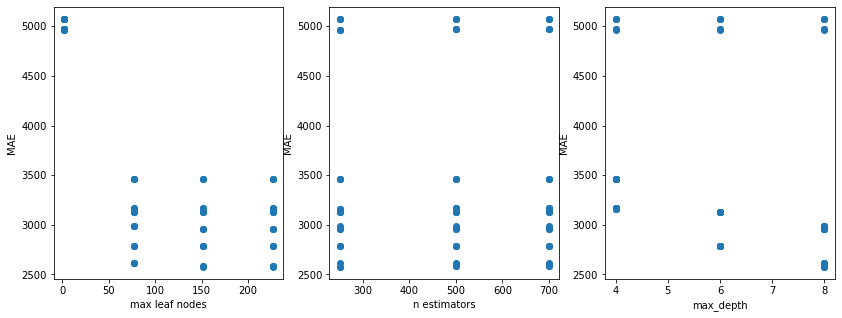

In [97]:
fig, axes = plt.subplots(1,3,figsize=(14,5))
plt.subplots_adjust(wspace=0.2)
axes[0].plot(rf_results.param_max_leaf_nodes, (-rf_results.mean_test_score), 'o')
axes[0].set_xlabel('max leaf nodes')
axes[0].set_ylabel('MAE')
axes[1].plot(rf_results.param_n_estimators,(-rf_results.mean_test_score), 'o')
axes[1].set_xlabel('n estimators')
axes[1].set_ylabel('MAE');
axes[2].plot(rf_results.param_max_depth,(-rf_results.mean_test_score), 'o')
axes[2].set_xlabel('max_depth')
axes[2].set_ylabel('MAE');

In [ ]:
#### fine grid search

In [98]:
rf_params2 = {'n_estimators': [500, 700, 900], 
            'max_depth': [6, 8, 10], 
            'max_leaf_nodes': range(250, 350, 15)}

rf_grid2 = GridSearchCV(RandomForestRegressor(random_state = 4, bootstrap = True), rf_params2, n_jobs = -1, verbose = 1, 
                       scoring = 'neg_root_mean_squared_error')
rf_grid2.fit(X_train, y_train)

print("Best RandomForest parameters:", rf_grid2.best_params_)
print("Best model train RMSE:", mean_squared_error(y_train, rf_grid2.predict(X_train), squared = False))
print("Best model test RMSE:", mean_squared_error(y_test, rf_grid2.predict(X_test), squared = False))
print("Best model R^2:", r2_score(y_test, rf_grid2.predict(X_test)))
rf_feats2 = pd.DataFrame(zip(rf_grid2.best_estimator_.feature_names_in_, rf_grid2.best_estimator_.feature_importances_)).reset_index()
rf_feats2.sort_values(by = rf_feats2.columns[2], ascending = False)

Fitting 5 folds for each of 63 candidates, totalling 315 fits
Best RandomForest parameters: {'max_depth': 10, 'max_leaf_nodes': 340, 'n_estimators': 500}
Best model train RMSE: 1424.986609472238
Best model test RMSE: 2385.598110495618
Best model R^2: 0.8408281485903418


,index,0,1
13,13,trimId,0.384392
8,8,model_name,0.216342
10,10,power,0.119587
7,7,mileage,0.105961
12,12,torque,0.030705
16,16,year,0.022599
4,4,height,0.014340
11,11,savings_amount,0.014279
6,6,length,0.012538
21,21,engine_cylinders_V6,0.010676


The best RMSE and R^2 resulted from the fine random forest grid search using our feature selection. This is because our feature selection was done using random forest. 

Our best random forest RMSE and R2 are 2385.598110495618 and 0.8408281485903418 respectively. 

### AdaBoost & Gradient boosting
*By YuYan Zhang*

### XGBoost
*By Emily Leibfritz*

## Model Ensemble 

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.**


### Voting ensemble

### Stacking ensemble(s)

### Ensemble of ensembled models

### Innovative ensembling methods
*(Optional)*

## Conclusions and Recommendations to stakeholder(s)

You may or may not have code to put in this section. Delete this section if it is irrelevant.